# Project - Grinding Dynamic Simulation Model

In [1]:
from platform import python_version
python_version()

'3.7.6'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

## Grinding Model Differential Equations

In [3]:
def f_dxdt(t, x, feed, r, b_matrix, d):
    """Ordinary differential equations describing the rate of change of
    mill charge in each size fraction.  This is the 'General Grinding
    Model' described in Molycop Tools spreadsheet (Eq. 3).  Note, t is
    redundant in this case but is included for compatibility with
    numerical solvers which are designed for the general case where dxdt
    can be a function of time also.
    
    Args:
        t (float): Time (mins).
        x (array): Charge load (tons).
        feed (np.ndarray): Mill feed (tons).
        r (array): Breakage rates (selection function).
        b_matrix (array): Breakage matrix (appearance functions).
        d (array): Discharge grate efficiencies.
    """
    A = r*(b_matrix - np.eye(b_matrix.shape[0])) - np.diag(d)
    return feed + A @ x

In [4]:
def solve(t, x0, dxdt, timestep_size, args, method='Radau'):
    """Estimates x at time t + timestep by starting at x0 and
    using the derivate function dxdt to numerically solve the
    initial value problem.
    
    Args:
        t: (float): Initial time.
        x0 (array): Initial x at time t (i.e. x[t]). 
        dxdt (function): Function which returns the derivative of x.
        timestep_size (float): Timestep to increment by.
        args (list): Additional arguments to pass to dxdt.
    
    Returns:
        x2 (array): State vector at time t + timestep_size.
    """
    t2 = t + timestep_size
    sol = solve_ivp(dxdt, t_span=[t, t2], y0=x0, method=method,
                    args=args)
    assert sol.status == 0, "Solver failed."

    return sol.y[:, -1]

## Unit Tests

In [5]:
# Calculation example with 3 size intervals

# Feed rates
feed = np.array([ 2,  1,  0.5])

# Discharge rate function
d_max = 0.2  # Transport to grate
c = np.array([  0, 0.5, 1.0])  # Grate classification function
d = d_max * c

# Breakage rates
r = np.array([0.2, 0.25, 0.0])

assert r[-1] == 0.0  # r=0 for smallest size fraction
assert all((r + d) <= 1)

# Initial charge
x0 = np.array([30, 30, 30])

# Breakage matrix
b_matrix = np.array([
    [  0,   0,   0],
    [0.5,   0,   0],
    [0.5, 1.0,   0]
])

assert all(sum(b_matrix)[:-1] == 1)

n_sizes = x0.shape[0]
assert feed.shape == (n_sizes, )
assert d.shape == (n_sizes, )
assert r.shape == (n_sizes, )

In [6]:
# Test derivative calculations
t = 0
dxdt = f_dxdt(t, x0, feed, r, b_matrix, d)
dxdt

array([-4. , -6.5,  5. ])

In [7]:
# Rate of change of charge - size 1
dxdt1_true = (feed[0] - x0[0] * r[0]) * (1 - d[0])
assert dxdt[0] == dxdt1_true
dxdt[0], dxdt1_true

(-4.0, -4.0)

In [8]:
breakage = x0 * r
discharge = x0 * d

In [9]:
# Rate of change of charge - size 2
dxdt2_true = (feed[1]
    + breakage[0] * b_matrix[1, 0]
    - breakage[1]
    - discharge[1]
)
assert dxdt[1] == dxdt2_true
dxdt[1], dxdt2_true

(-6.5, -6.5)

In [10]:
# Rate of change of charge - size 3
dxdt3_true = (feed[2]
    + breakage[0] * b_matrix[2, 0]
    + breakage[1] * b_matrix[2, 1]
    - breakage[2]
    - discharge[2]
)
assert np.isclose(dxdt[2], dxdt3_true)
dxdt[2], dxdt3_true

(5.0, 5.0)

In [11]:
# How to calculate discharge rate
discharge_rate = d*x0
discharge_rate

array([0., 3., 6.])

In [12]:
# Mill flows
np.stack([feed, dxdt, discharge]).T

array([[ 2. , -4. ,  0. ],
       [ 1. , -6.5,  3. ],
       [ 0.5,  5. ,  6. ]])

In [13]:
# Check overall mass balance
print(feed.sum(), dxdt.sum(), discharge_rate.sum())
assert dxdt.sum() == feed.sum() - discharge_rate.sum()

3.5 -5.5 9.0


In [14]:
# Test solver
t = 0
timestep_size = 0.5
x1 = solve(t, x0, f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
x1

array([28.09674836, 26.97283772, 32.14492609])

In [15]:
# Test solution with difference estimates
t = 0
timestep_size = 0.01  # Small timestep
x1 = solve(t, x0, f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
dxdt_est = (x1 - x0) / timestep_size
dxdt_true = f_dxdt(t, x0, feed, r, b_matrix, d)

assert np.isclose(dxdt_est, dxdt_true, atol=0.05).all()

print(dxdt_est, dxdt_true)

[-3.99600267 -6.4906346   4.98489421] [-4.  -6.5  5. ]


## Simulate over time

In [16]:
# Number of timesteps
nt = 50
timestep_size = 0.5

# Feedrate
feed_rates = np.repeat(feed.reshape(1,-1), nt+1, axis=0)

# Increase feedrate after 30 timesteps
feed_rates[30:] = 2 * feed_rates[30:]

# Initialize variables
x = np.zeros((nt+1, n_sizes))
discharge_rates = np.zeros((nt+1, n_sizes))
x[0] = x0

t = np.arange(nt+1) * timestep_size
for k in range(1, nt+1):
    feed = feed_rates[k]
    x[k, :] = solve(t[k], x[k-1], f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
    discharge_rates[k] = d*x[k]

In [17]:
# Convert results to dataframe
labels = [f'$x_{i+1}$' for i in range(n_sizes)]
index = pd.Index(t, name='t')
charge_weights = pd.DataFrame(x, columns=labels, index=index)
charge_weights.round(2).head()

,$x_1$,$x_2$,$x_3$
t,,,
0.0,30.00,30.00,30.00
0.5,28.10,26.97,32.14
1.0,26.37,24.35,33.66
1.5,24.82,22.07,34.67
2.0,23.41,20.09,35.26


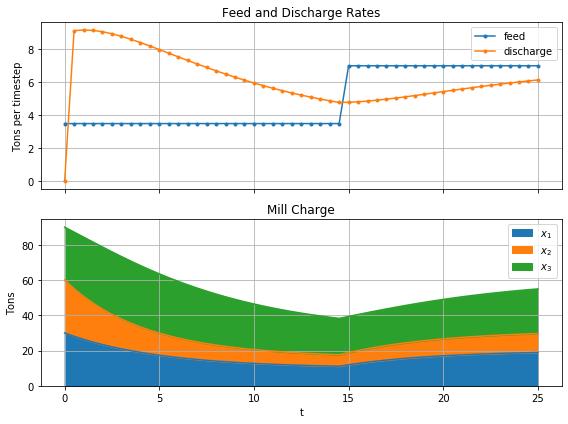

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)

ax = axes[0]
ax.plot(t, feed_rates.sum(axis=1), '.-', label='feed')
ax.plot(t, discharge_rates.sum(axis=1), '.-', label='discharge')
ax.set_title('Feed and Discharge Rates')
ax.set_xlabel('t')
ax.set_ylabel('Tons per timestep')
ax.grid()
ax.legend()

ax = axes[1]
charge_weights.plot.area(ax=ax, stacked=True)
ax.set_title('Mill Charge')
ax.set_ylabel('Tons')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

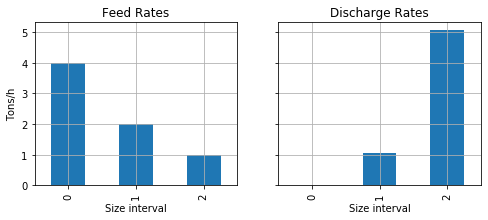

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,3))

ax = axes[0]
pd.Series(feed_rates[-1]).plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Feed Rates')
ax.grid()

ax = axes[1]
pd.Series(discharge_rates[-1]).plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Discharge Rates')
ax.grid()

plt.show()

## Setup Full-Scale Simulation

In [20]:
from molycop.models import StaticBreakageFunction

In [21]:
mesh_dimensions = {
    'Size Interval': np.arange(1, 27),
    'Size': [
        16, 8, 4, 3, 2, 1.05, 0.742, 0.525, 0.371,
        3, 4, 6, 8, 10, 14, 20, 28, 35, 48, 65,
        100, 150, 200, 270, 400, -400
    ],
    'Opening': [
        406400, 203200, 101600, 76100, 50800,
        25400, 19050, 12700, 9500, 6700,
        4750, 3350, 2360, 1700, 1180,
        850, 600, 425, 300, 212,
        150, 106, 75, 53, 38, 0
    ]
}

mesh = pd.DataFrame(mesh_dimensions).set_index('Size Interval')
mesh.head()

,Size,Opening
Size Interval,,
1,16.0,406400
2,8.0,203200
3,4.0,101600
4,3.0,76100
5,2.0,50800


In [22]:
mesh_openings = (mesh['Opening'].iloc[:-1]).values
mesh_openings

array([406400, 203200, 101600,  76100,  50800,  25400,  19050,  12700,
         9500,   6700,   4750,   3350,   2360,   1700,   1180,    850,
          600,    425,    300,    212,    150,    106,     75,     53,
           38])

In [23]:
# Deafult selection and breakage model from Molycop Tools SAGSim model
selection_params = {
    'Balls': {'alpha0': 0.00358000, 'alpha1': 0.650,
              'alpha2': 3.500, 'dcrit': 25400},
    'Rocks': {'alpha0': 0.00228000, 'alpha1': 0.650,
              'alpha2': 3.500, 'dcrit': 9500},
    'Self': {'alpha0': 0.00018, 'alpha1': 0.650}
}

breakage_params = {
    'beta00': 0.400,
    'beta01': 0.050,
    'beta1': 0.650,
    'beta2': 2.500,
    'beta30': 0.127,
    'beta31': 0.000
}
breakage_function = StaticBreakageFunction(selection_params, breakage_params)
breakage_function

In [24]:
b_matrix = breakage_function.calculate_breakage_matrix(mesh_openings)
b_matrix.shape

(25, 25)

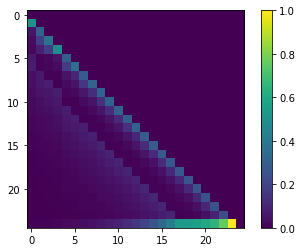

In [25]:
# Visualize B[i, j] matrix
plt.imshow(b_matrix, cmap='viridis')
plt.colorbar()
plt.show()